In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install rembg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.0 MB/s eta 0:00:00


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models, utils
from PIL import Image
import numpy as np
from rembg.bg import remove
import io

In [11]:
input_path = '/content/drive/My Drive/NST-img/pigeon_brown.jpeg'
style_path = '/content/drive/My Drive/NST-img/gohho.jpeg'
greenback_path = '/content/drive/My Drive/NST-img/greenback.jpeg'
#画像ファイルをバイトストリームとして読み込む
with open(input_path, 'rb') as f:
    image_data = f.read()
result = remove(image_data,
                alpha_matting=True,
                alpha_matting_foreground_threshold=240,
                alpha_matting_background_threshold=10,
                alpha_matting_erode_structure_size=6)

cut_img = Image.open(io.BytesIO(result)).convert("RGBA")

100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 79.8GB/s]


In [12]:
def scale_to_width(img, width):  #アスペクト比を固定して、幅が指定した値になるようリサイズする関数。
    height = round(img.height * width / img.width) #横幅からアスペクト比をもとに高さを計算
    return img.resize((width, height)) #リサイズし、return

In [13]:
bg = Image.open(greenback_path).convert('RGBA').resize(cut_img.size)
#画像合成(透明度要素alphaも適用)
merge = Image.alpha_composite(bg, cut_img)

In [14]:
#既存のモデルを使用
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 126MB/s] 


In [15]:
#GPUで動かすように設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [16]:
#読み込んだ画像のサイズや様式を変更
def load_image(image, max_size=400, shape=None):

  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape:
    size = shape
  in_transform = transforms.Compose([
                    transforms.Resize(size),
                    transforms.ToTensor()])

  image = in_transform(image).unsqueeze(0)

  return image


In [17]:
content = load_image(merge.convert('RGB')).to(device)
style = load_image(Image.open(style_path).convert('RGB'), shape=content.shape[-2:]).to(device)

In [18]:
def im_convert(tensor):
  #Tensorをnp.arrayに変換する
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5, 0.5, 0.5) + np.array((0.5, 0.5, 0.5)))
  image = image.clip(0, 1)

  return image

In [19]:
def get_features(image, model):
  #Feature Extraction
  #特徴を抜き出すレイヤー
  layers = {'0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',
            '28': 'conv5_1',}

  features = {}

  for name, layer in model._modules.items():
    #CNNを回して
    image = layer(image)
    #特定のレイヤーで特徴を抽出する
    #ここでは　0番　5番　10番　19番　21番　28番
    if name in layers:
      features[layers[name]] = image

  return features


In [20]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [21]:
def gram_matrix(tensor):
    """
    note : グラム行列の計算(X.T @ X)
    ----------
    tensor : tensor
    ----------
    """
    #arbitrary vector times vector.T
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [22]:
style_grams = {layer : gram_matrix(style_features[layer]) for layer in style_features}


style_weights = {
    "conv1_1" : 1.,
    "conv2_1" : 0.75,
    "conv3_1" : 0.2,
    "conv4_1" : 0.2,
    "conv5_1" : 0.2
}
content_weight = 1
style_weight = 1e6

In [23]:
target = content.clone().requires_grad_(True).to(device)

In [24]:
# 300iterlationごとに可視化
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 3300
total_capture_frame_number = 500

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(total_capture_frame_number, height, width, channels))
capture_frame =steps/total_capture_frame_number
counter = 0

In [25]:
for ii in range(1, steps+1):
  target_features = get_features(target, vgg)
  #コンテンツとの損失関数の計算
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  #スタイルとの損失関数の計算
  style_loss = 0

  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    #重み * 二乗和誤差
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)

  #トータルの損失関数
  total_loss = content_weight * content_loss + style_weight * style_loss

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

In [26]:
cutting_result_changed = remove((im_convert(target)* 255).astype(np.uint8),
                alpha_matting=True,
                alpha_matting_foreground_threshold=240,
                alpha_matting_background_threshold=10,
                alpha_matting_erode_structure_size=6)

In [27]:
style_changed = Image.open(input_path).convert('RGBA')
cut_img_changed = Image.fromarray(cutting_result_changed).convert('RGBA').resize(style_changed.size)
merge_changed = Image.alpha_composite(style_changed, cut_img_changed)

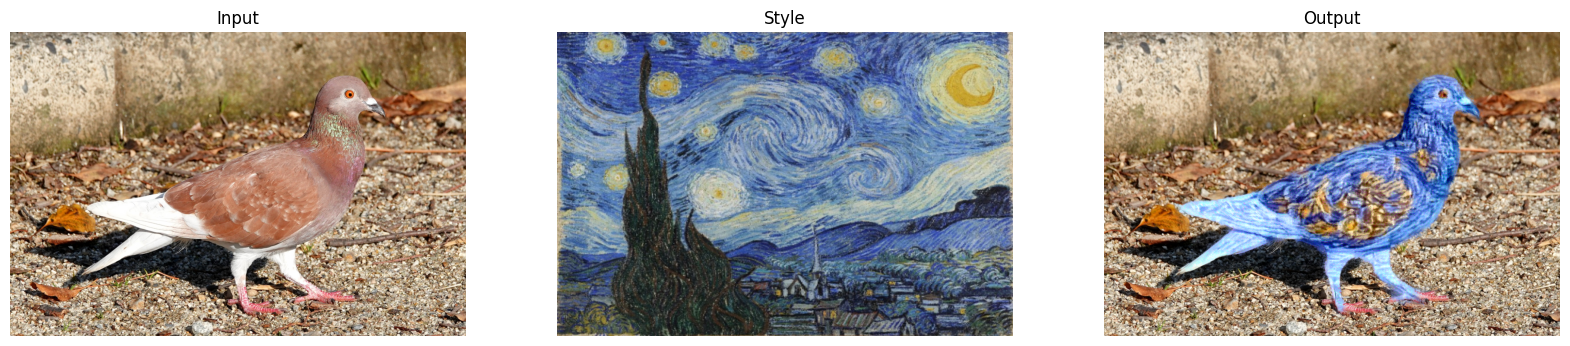

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
imgs = [style_changed, im_convert(style) , merge_changed]
names = ['Input', 'Style', 'Output']

for i, im, name in zip(range(len(ax)), imgs, names):
    img = im
    ax[i].imshow(img)
    ax[i].set_title(name)
    ax[i].axis('off')

plt.show()